# Handwritten Digits Classification via SVD

> *Numerical Optimization and Large Scale Linear Algebra*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>Construct an algorithm for classification of handwritten digits. Use a training set, and compute the SVD of each class matrix. Use the first few (5-20) singular vectors as basis and classify unknown test digits according to how well they can be represented in terms of the respective bases (use the relative residual vector in the lest squares problem as a measure).</p>

<p style='text-align: justify;'><i>Question 1</i><br>Tune the algorithm for accuracy of classification.<br>Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.</p>

<p style='text-align: justify;'><i>Question 2</i><br>Check if all digits are equally easy or difficult to classify.<br>Also look at some of the difficult ones, and see that in many cases they are very badly written.</p>

<p style='text-align: justify;'><i>Question 3</i><br>Check the singular values of the different classes.<br>Is it motivated to use different numbers of basis vectors for different classes?<br>If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.</p>

<p style='text-align: justify;'><i>Optional</i><br>In order to save operations in the test phase, implement a two-stage algorithm.<br>In the first stage compare the unknown digit only to the first singular vector in each class.<br>If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above.<br>Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?</p>

## *Table of Contents*

- [*1. Libraries*](#libraries)
- [*2. Data*](#data)
- [*3. Singular Value Decomposition*](#svd)
- [*4. Least Squares Classification Algorithm*](#ls_classifier)
- [*5. Question 1 - Fine Tune Number Of Basis Vectors For Accuracy Of Classification*](#q1)
- [*6. Question 2 - Classification Metrics Results & Badly Written Digits*](#q2)
- [*7. Question 3 - Singular Values Per Digit & Different Number Of Basis Vectors For Different Classes*](#q3)
- [*8. Optional - Two-Stage Classification Algorithm*](#optional)

---

## Libraries <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tabulate import tabulate
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Data <a class='anchor' id='data'></a>

- The data are a subset of the US Postal Service Database
- The file *data.xslx* contains both training and test data
- The sheet *\"azip" ("testzip")* holds the training (test) images as an array of dimension $256 \times 1707$
- The images are vectors of dimension $256$, that have been constructed from $16 \times 16$ images
- The sheet *\"dzip" ("dtest")* holds the digits (numbers) as a vector of dimension $1 \times 1707$

##### *Read the data*

In [2]:
# read train data
x_train = pd.read_excel('./data/data.xlsx', sheet_name='azip', header=None)
y_train = pd.read_excel('./data/data.xlsx', sheet_name='dzip', header=None)
y_train = np.asarray(y_train).reshape((y_train.shape[1]))

# read test data
x_test = pd.read_excel('./data/data.xlsx', sheet_name='testzip', header=None)
y_test = pd.read_excel('./data/data.xlsx', sheet_name='dtest', header=None)
y_test = np.asarray(y_test).reshape((y_test.shape[1]))

# shapes
print(f'x_train.shape: {x_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f' x_test.shape: {x_test.shape}')
print(f' y_test.shape: {y_test.shape}')

# preview x_train
x_train.head()

x_train.shape: (256, 1707)
y_train.shape: (1707,)
 x_test.shape: (256, 2007)
 y_test.shape: (2007,)


,0,1,2,3,4,5,6,7,8,9,...,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706
0,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000
1,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000
2,-1.0,-1.000,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.0,-1.0,...,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000
3,-1.0,-0.813,-1.0,-1.0,-1.0,-1.0,-0.830,-1.0,-1.0,-1.0,...,-1.000,-0.567,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000,-1.0,-1.000
4,-1.0,-0.671,-1.0,-1.0,-1.0,-1.0,0.442,-1.0,-1.0,-1.0,...,-0.986,-0.064,-1.0,-1.0,-1.0,-1.0,-1.0,-0.948,-1.0,-0.338


##### *Count the number of distinct images per digit in both train and test set*

In [3]:
def count_digit_frequency(y_train, y_test):
    
    # count each digit's frequency for train set
    digits_train, counts_train = np.unique(y_train, return_counts=True)
    
    print('# Train set \n' + '='*33)
    # display frequency
    for digit in range(10):
        print(f'There are {counts_train[digit]} images for digit {digits_train[digit]}.')
        
    # count each digit's frequency for test set
    digits_test, counts_test = np.unique(y_test, return_counts=True)
    
    print('\n# Test set \n' + '='*33)
    # display frequency
    for digit in range(10):
        print(f'There are {counts_test[digit]} images for digit {digits_test[digit]}.')
    
    return

# execute function
_ = count_digit_frequency(y_train, y_test)

# Train set 
There are 319 images for digit 0.
There are 252 images for digit 1.
There are 202 images for digit 2.
There are 131 images for digit 3.
There are 122 images for digit 4.
There are 88 images for digit 5.
There are 151 images for digit 6.
There are 166 images for digit 7.
There are 144 images for digit 8.
There are 132 images for digit 9.

# Test set 
There are 359 images for digit 0.
There are 264 images for digit 1.
There are 198 images for digit 2.
There are 166 images for digit 3.
There are 200 images for digit 4.
There are 160 images for digit 5.
There are 170 images for digit 6.
There are 147 images for digit 7.
There are 166 images for digit 8.
There are 177 images for digit 9.


##### *Plot some digits*

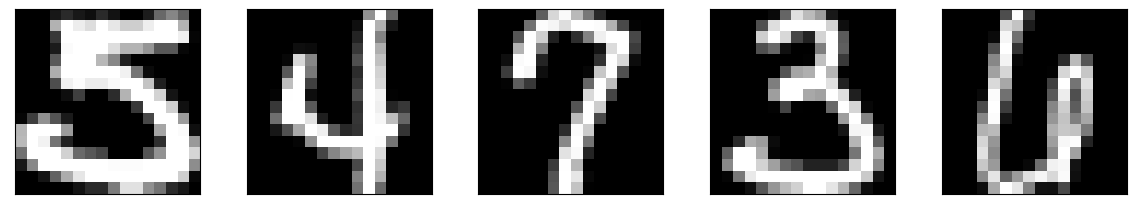

In [4]:
# create figure
fig, ax = plt.subplots(1,5,figsize=(12,6),dpi=100,facecolor='white')
# plot random digit images
ax[0].imshow(np.asarray(x_train.iloc[:,1]).reshape((16,16)), cmap='gray')
ax[1].imshow(np.asarray(x_train.iloc[:,2]).reshape((16,16)), cmap='gray')
ax[2].imshow(np.asarray(x_train.iloc[:,3]).reshape((16,16)), cmap='gray')
ax[3].imshow(np.asarray(x_train.iloc[:,4]).reshape((16,16)), cmap='gray')
ax[4].imshow(np.asarray(x_train.iloc[:,5]).reshape((16,16)), cmap='gray')
for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout(pad=3)
fig.savefig('./images/digit_examples.svg')
plt.show()

## Singular Value Decomposition <a class='anchor' id='svd'></a>

<p style='text-align: justify;'>In linear algebra, <b>the singular value decomposition (SVD)</b> is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any $m \times n$ matrix. It is related to the polar decomposition.</p>

<p style='text-align: justify;'>Specifically, the singular value decomposition of an $m \times n$ complex matrix $M$ is a factorization of the form $M=UΣV^{*}$, where $U$ is an $m \times m$ complex unitary matrix, $Σ$ is a $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $n \times n$ complex unitary matrix. If $M$ is real, $U$ and $V$ can also be guaranteed to be real orthogonal matrices. In such contexts, the <b>SVD</b> is often denoted $UΣV^{T}$</p>

##### *Define function to compute SVD*

In [5]:
def svd_computation(x_set, y_set, digit):
    """
    Singular Value Decomposition
    ____________________________
    :param x_set: the input training data
    :param y_set: the labels of the training data
    :param digit:
    :return: the U, S, V matrices
    ============================
    step1: compute the singular value decomposition of the given digit images
    """

    # get the dataframe indices
    # corresponding to the input digit
    idx = np.where(y_set == digit)[0]
    
    # define matrix A
    A = x_set.iloc[:,idx]
    
    # compute SVD
    U, S, V = np.linalg.svd(A)
    
    return U, S, V

# initialize U,S,V
U_matrix, S_matrix, V_matrix = list(), list(), list()

# loop through digits
for digit in range(0, 10):
    # execute the function and append U
    U_matrix.append(svd_computation(x_train, y_train, digit)[0])
    # execute the function and append S
    S_matrix.append(svd_computation(x_train, y_train, digit)[1])
    # execute the function and append V
    V_matrix.append(svd_computation(x_train, y_train, digit)[2])

## Least Squares Classification Algorithm <a class='anchor' id='ls_classifier'></a>

- After applying ***SVD***, the $U$ matrix of each class can be used to construct the classification algorithm
- In particular, we will create a least squares classification algorithm which will use the relative residual vector as a measure
- The residuals will be calculated based on the following function:

$$ \frac {\lVert (I-U_{k}U_{k}^{T})z \rVert_{2}}{\lVert z \rVert_{2}} $$

##### *Define function for the least squares classifier*

In [6]:
def least_squares_classifier(x_set, U_matrix, n_sing_vect):
    """
    Least Squares Classifier
    ________________________
    :param x_set: the data to be classified
    :param U_matrix: the U matrix obtained from SVD
    :param n_sing_vect: the number of singular vectors to use
    :return y_hat: the prediction estimates
    ========================
    step1: compute the residuals as the formula norm((I - (U * U_T)) * z)/norm(z)
    step2: find the class (digit) in which the smallest residual belongs
    step3: classify in that class the image in loop
    """
    
    # initialize a list
    # to store the predictions
    y_hat = list()
    
    # loop through images
    for image_col in range(x_set.shape[1]):
        
        # get the ith image vector (pixel values)
        z = x_set.iloc[:,image_col]
        
        # initialize a list
        # to store the residuals
        residuals = list()
        
        # loop through digits
        for digit in range(10):
            
            # compute the U
            # of the digit in loop
            U = U_matrix[digit]
            
            # get the first <<n_sing_vect>> singular vectors
            U = U[:, :n_sing_vect]
            
            # create the identity matrix
            I = np.identity(U.shape[0])
            
            # create the U transpose matrix
            U_T = np.transpose(U)
            
            # compute the numerator
            # norm((I - (U * U_T)) * z)
            numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
            # compute the residual
            # for the digit in loop
            residual = numerator / np.linalg.norm(z)
            
            # append residual to residuals list
            residuals.append(residual)
            
        # get the minimum residual
        # which corresponds to the most probable digit (estimate)
        estimate = np.argmin(residuals)
        
        # append the estimate
        y_hat.append(estimate)
        
    # convert y_hat to a (<<number of images>>,) vector
    y_hat = np.array(y_hat).reshape((len(y_hat),))
    
    return y_hat

## Question 1 <a class='anchor' id='q1'></a>

- *Tune the algorithm for accuracy of classification.*  
- *Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.*

##### *Define function to find the number of basis vectors that yields the highest accuracy results*

In [7]:
def tune_number_of_basis_vectors(x_set, y_set, U_matrix, basis_vectors_range):

    # initialize list
    # to store the accuracy per number of basis vectors
    basis_vectors_and_accuracy = list()

    # loop through first 5-20 singular vectors as basis vectors
    for n_basis_vect in basis_vectors_range:
        
        # print progress
        print(f'Running for {n_basis_vect} basis vectors...')

        # get classification estimates
        estimates = least_squares_classifier(x_set, U_matrix, n_basis_vect)
            
        # calculate accuracy
        accuracy = accuracy_score(y_set, estimates)
    
        # append number of basis vectors and accuracy
        basis_vectors_and_accuracy.append([n_basis_vect, accuracy])
    
    # create a dataframe with the results
    acc_results = pd.DataFrame(basis_vectors_and_accuracy, columns=['basis_vectors','accuracy'])
    
    # print results
    print('\n' + tabulate(acc_results, headers='keys', tablefmt='psql'), end='\n\n')
    
    return acc_results

# set starting time
start_time = datetime.now()

# execute function
acc_results = tune_number_of_basis_vectors(x_train, y_train, U_matrix, range(5,21))

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

Running for 5 basis vectors...
Running for 6 basis vectors...
Running for 7 basis vectors...
Running for 8 basis vectors...
Running for 9 basis vectors...
Running for 10 basis vectors...
Running for 11 basis vectors...
Running for 12 basis vectors...
Running for 13 basis vectors...
Running for 14 basis vectors...
Running for 15 basis vectors...
Running for 16 basis vectors...
Running for 17 basis vectors...
Running for 18 basis vectors...
Running for 19 basis vectors...
Running for 20 basis vectors...

+----+-----------------+------------+
|    |   basis_vectors |   accuracy |
|----+-----------------+------------|
|  0 |               5 |   0.970709 |
|  1 |               6 |   0.973638 |
|  2 |               7 |   0.976567 |
|  3 |               8 |   0.981839 |
|  4 |               9 |   0.981839 |
|  5 |              10 |   0.985354 |
|  6 |              11 |   0.987112 |
|  7 |              12 |   0.987698 |
|  8 |              13 |   0.989455 |
|  9 |              14 |   0.991213 

- We ran the model for different numbers of basis vectors (5-20) and we obtained the results
- It seems that we have a winner in terms of accuracy
- For 20 basis vectors, the model yields the highest accuracy

##### *Visualize the results*

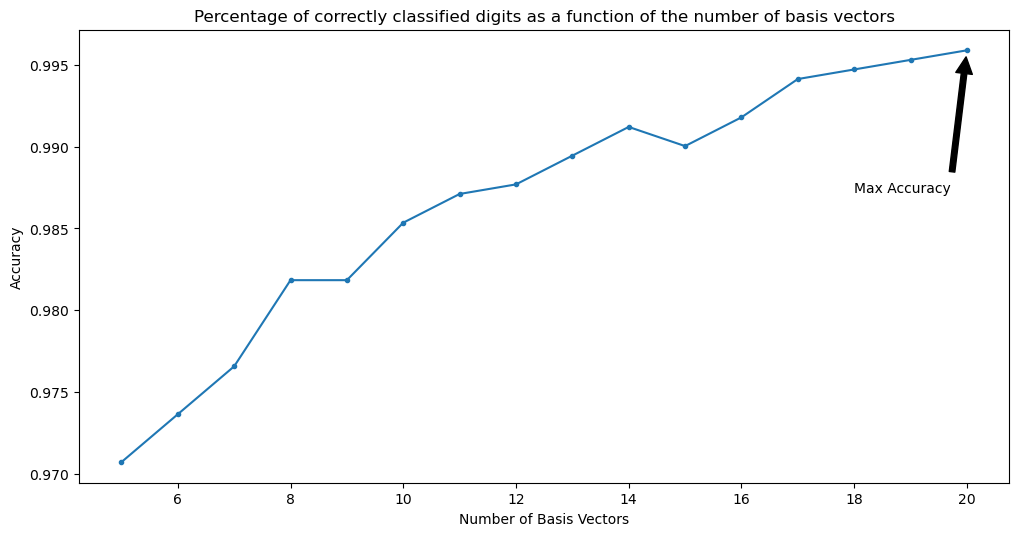

In [8]:
def plot_percentage_of_correctly_classified_digits(df):
    
    # create figures
    fig = plt.figure(figsize=(12,6),dpi=100,facecolor='white')
    ax = fig.add_subplot(111)
    
    # plot vectors vs accuracy
    plt.plot(df.basis_vectors, df.accuracy, marker='.')
    plt.xlabel('Number of Basis Vectors')
    plt.ylabel('Accuracy')
    plt.title('Percentage of correctly classified digits as a function of the number of basis vectors')
    
    # plot annotation
    y_max = df.accuracy.max()
    x_max = df[df.accuracy == y_max].basis_vectors.values[0]
    diff = (df.accuracy.max() - df.accuracy.min() - df.accuracy.std()) / 2
    ax.annotate('Max Accuracy', xy=(x_max, y_max), xytext=(x_max-2, y_max-diff), arrowprops=dict(facecolor='black', shrink=0.05))
    plt.savefig('./images/accuracy_per_no_basis_vectors.svg')
    plt.show
    
    return

# execute function
_ = plot_percentage_of_correctly_classified_digits(acc_results)

## Question 2 <a class='anchor' id='q2'></a>

- *Check if all digits are equally easy or difficult to classify.*
- *Also look at some of the difficult ones, and see that in many cases they are very badly written.*

##### *Process*

- For this task, we will use the optimal number of basis vectors (20) that we found above
- Then we will run the least squares classifier to obtain the estimates
- Finally, we will display some classification metrics to check if there are digits that are easy / hard to classify

##### *Run the model and get the estimates*

In [9]:
# ls estimates
y_hat = least_squares_classifier(x_test, U_matrix, 20)

##### *Define function to display the classification metrics results*

In [10]:
def view_classification_metrics(y_set, y_hat):

    # compute classification report
    class_report = classification_report(y_set, y_hat)
    
    # compute confusion matrix
    conf_matrix = confusion_matrix(y_set, y_hat)
    
    # print results
    print('Classification report using SVD with 20 basis vectors')
    print('='*53)
    print(class_report, end='\n\n')
    print('Confusion matrix using SVD with 20 basis vectors')
    print('='*53)
    print(conf_matrix, end='\n\n')
    
    return

# execute function
_ = view_classification_metrics(y_test, y_hat)

Classification report using SVD with 20 basis vectors
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       359
           1       0.98      0.98      0.98       264
           2       0.94      0.90      0.92       198
           3       0.92      0.89      0.91       166
           4       0.92      0.94      0.93       200
           5       0.92      0.88      0.90       160
           6       0.98      0.96      0.97       170
           7       0.94      0.95      0.94       147
           8       0.94      0.90      0.92       166
           9       0.90      0.94      0.92       177

    accuracy                           0.94      2007
   macro avg       0.94      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007


Confusion matrix using SVD with 20 basis vectors
[[355   0   2   0   1   0   0   0   0   1]
 [  0 259   0   0   3   0   2   0   0   0]
 [  8   1 179   2   3   0   0   1   4   0]
 [  1   

- According to the results, the model seems to estimate better digits one (1) and six (6)
- On the other hand, the model seems to have more difficulty in estimating digits three (3) and five (5)
- For the latter, let's plot some of them and see if there are cases where they are very badly written

##### *Store digits 3 and 5 in respective arrays*

In [11]:
digit_3 = np.asarray(x_test.iloc[:,np.where(y_test == 3)[0]])
digit_5 = np.asarray(x_test.iloc[:,np.where(y_test == 5)[0]])

##### *Define function to convert an image vector to the appropriate form (according to the ima2.m function)*

In [12]:
def ima2_function(image_vector):
    # reshape image from vector (n^2,0) to matrix (n,n) 
    image = image_vector.reshape((16,16))
    # scale image to become non-negative
    image = (image - np.min(image)) * len(image)
    # scale image to interval [0,20]
    image = (20 / np.max(image)) * image
    return image

##### *Plot some random digits 3*

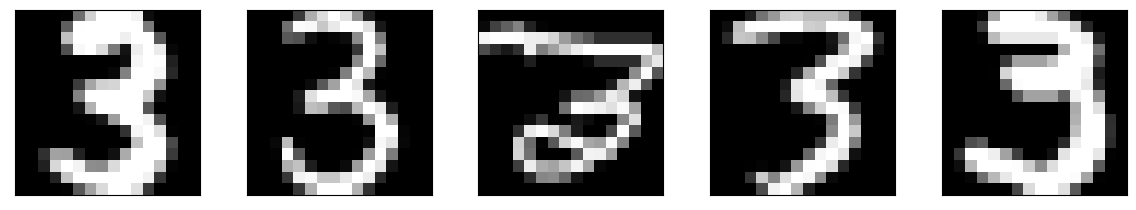

In [13]:
# create figure
fig, ax = plt.subplots(1,5,figsize=(12,6),dpi=100,facecolor='white')
for i in range(5):
    # select random image
    random_image = digit_3[:,np.random.RandomState((i+8)**i).choice(range(digit_3.shape[1]))]
    # convert image to appropriate form
    image = ima2_function(random_image)
    # plot image
    ax[i].imshow(image, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    fig.tight_layout(pad=3)
    fig.savefig('./images/digit_three.svg')
    fig.show()

##### *Plot some random digits 5*

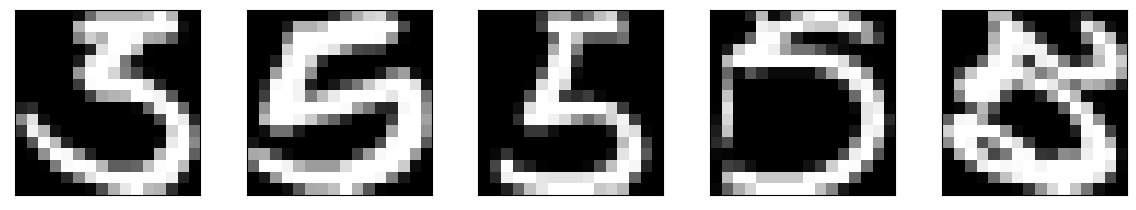

In [14]:
# create figure
fig, ax = plt.subplots(1,5,figsize=(12,6),dpi=100,facecolor='white')
for i in range(5):
    # select random image
    random_image = digit_5[:,np.random.RandomState((i+4)**i).choice(range(digit_5.shape[1]))]
    # convert image to appropriate form
    image = ima2_function(random_image)
    # plot image
    ax[i].imshow(image, cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    fig.tight_layout(pad=3)
    fig.savefig('./images/digit_five.svg')
    fig.show()

- Well, indeed! There are cases where some of these digits are badly written.
- In some cases, they are so badly written that can be mistaken even by a human.
- We can see that in the first case of digit 5, the digit looks more a three than a five.

## Question 3 <a class='anchor' id='q3'></a>

- *Check the singular values of the different classes.*
- *Is it motivated to use different numbers of basis vectors for different classes?*
- *If so, perform a few experiments to find out if it really pays off to use fewer basis vectors in one or two of the classes.*


##### *Process*

- First, we will plot the singular values to find the digits for which these values decrease the fastest
- Then, for these digits, we will try to find the number of basis vectors that yields the highest accuracy
- Finally, we will run the model to see if using a different number of basis vectors for certain digits yields in general better results.

##### *Plot the first 10 singular values per digit*

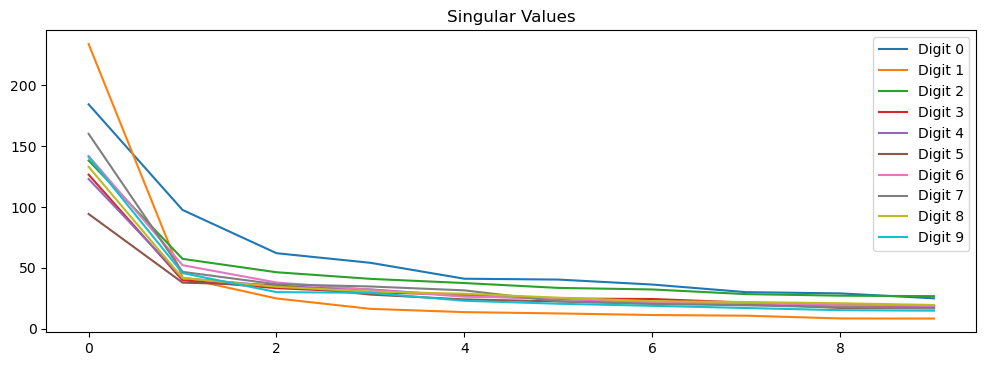

In [15]:
def plot_singular_values(x_set, y_set, n_sing_values):
    
    # create figure
    plt.figure(figsize=(12,4),dpi=100,facecolor='white')
    
    # loop through digits
    for digit in range(10):
        
        # compute singular values
        singular_values = (svd_computation(x_set, y_set, digit)[1]).reshape(-1,1)
        
        # plot singular values
        plt.plot(singular_values[:n_sing_values], label=f'Digit {digit}')
        
    plt.title('Singular Values')
    plt.legend()
    plt.savefig('./images/singular_values.svg')
    plt.show()
    
    return

# execute function
_ = plot_singular_values(x_train, y_train, 10)

- According to the graph, we see that the singular values of digit 1 decrease much faster than of the rest of the digits.
- Therefore, we will try to see if using a different number of basis vectors for this digit will yield better results.

##### *Modify the least squares classifier function to run a few experiments*

In [16]:
def least_squares_classifier_exp(x_set, U_matrix, n_sing_vect, digit_exp, n_sing_vect_exp):
    """
    Least Squares Classifier
    ________________________
    :param x_set: the data to be classified
    :param U_matrix: the U matrix obtained from SVD
    :param n_sing_vect: the optimal number of singular vectors obtained from previous experiments
    :param digit_exp: the digit for which we will run the classifier using a different number of singular vectors
    :param n_sing_vect_exp: the number of singular vectors that will be used for the digit under experimentation
    :return y_hat: the prediction estimates
    ========================
    step1: compute the residuals as the formula  norm((I - (U * U_T)) * z)/norm(z)
    step2: find the class (digit) in which the smallest residual belongs
    step3: classify in that class the image in loop
    """
    
    # initialize a list
    # to store the predictions
    y_hat = list()
    
    # loop through images
    for image_col in range(x_set.shape[1]):
        
        # get the ith image vector (pixel values)
        z = x_set.iloc[:,image_col]
        
        # initialize a list
        # to store the residuals
        residuals = list()
        
        # loop through digits
        for digit in range(10):
            
            # if the digit in loop
            # is not a digit under experimentation
            if digit != digit_exp:
            
                # compute the U of the digit in loop
                U = U_matrix[digit]
            
                # get the first <<n_sing_vect>> singular vectors
                U = U[:, :n_sing_vect]
            
                # create the identity matrix
                I = np.identity(U.shape[0])
            
                # create the U transpose matrix
                U_T = np.transpose(U)
            
                # compute the numerator
                # norm((I - (U * U_T)) * z)
                numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
                # compute the residual
                # for the digit in loop
                residual = numerator / np.linalg.norm(z)
            
                # append residual to residuals list
                residuals.append(residual)
                
            # if the digit in loop
            # is a digit under experimentation
            else:
                
                # compute the U of the digit in loop
                U = U_matrix[digit_exp]
                
                # get the first <<n_sing_vect>> singular vectors
                U = U[:, :n_sing_vect_exp]
                
                # create the U transpose matrix
                U_T = np.transpose(U)
                
                # compute the numerator
                # norm((I - (U * U_T)) * z)
                numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
                # compute the residual
                # for the digit in loop
                residual = numerator / np.linalg.norm(z)
            
                # append residual to residuals list
                residuals.append(residual)
                
        # get the minimum residual
        # which corresponds to the most probable digit (estimate)
        estimate = np.argmin(residuals)
        
        # append the estimate
        y_hat.append(estimate)
        
    # convert y_hat to a (<<number of images>>,) vector
    y_hat = np.array(y_hat).reshape((len(y_hat),))
    
    return y_hat

##### *Modify the function that finds the optimal number of basis vectors to run a few experiments*

In [17]:
def tune_number_of_basis_vectors_exp(x_set, y_set, U_matrix, n_basis_vectors, digit_exp, basis_vectors_range_exp):

    # initialize list
    basis_vectors_and_accuracy = list()

    # loop through first 5-20 singular vectors as basis vectors
    for n_basis_vectors_exp in basis_vectors_range_exp:
        
        # print progress
        print(f'Running for {n_basis_vectors_exp} basis vectors...')

        # get classification estimates (for Question 1)
        estimates = least_squares_classifier_exp(x_set, U_matrix, n_basis_vectors, digit_exp, n_basis_vectors_exp)
            
        # calculate accuracy
        accuracy = accuracy_score(y_set, estimates)
    
        # append
        basis_vectors_and_accuracy.append([n_basis_vectors_exp, accuracy])
    
    # create a dataframe with the results
    acc_results = pd.DataFrame(basis_vectors_and_accuracy, columns=['basis_vectors','accuracy'])
    
    # print results
    print('\n' + tabulate(acc_results, headers='keys', tablefmt='psql'), end='\n\n')
    
    return acc_results

##### *Find the optimal number of basis vectors for digit 1*

In [18]:
# set starting time
start_time = datetime.now()

# run function
acc_results_exp = tune_number_of_basis_vectors_exp(x_train, y_train, U_matrix, 20, 1, range(5,21))

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

Running for 5 basis vectors...
Running for 6 basis vectors...
Running for 7 basis vectors...
Running for 8 basis vectors...
Running for 9 basis vectors...
Running for 10 basis vectors...
Running for 11 basis vectors...
Running for 12 basis vectors...
Running for 13 basis vectors...
Running for 14 basis vectors...
Running for 15 basis vectors...
Running for 16 basis vectors...
Running for 17 basis vectors...
Running for 18 basis vectors...
Running for 19 basis vectors...
Running for 20 basis vectors...

+----+-----------------+------------+
|    |   basis_vectors |   accuracy |
|----+-----------------+------------|
|  0 |               5 |   0.995313 |
|  1 |               6 |   0.996485 |
|  2 |               7 |   0.997071 |
|  3 |               8 |   0.997071 |
|  4 |               9 |   0.997071 |
|  5 |              10 |   0.997071 |
|  6 |              11 |   0.997071 |
|  7 |              12 |   0.997071 |
|  8 |              13 |   0.997071 |
|  9 |              14 |   0.997071 

##### *Optimize the least squares classifier function*

- For digit 1, the classifier will use 7 singular vectors
- For the rest of the digits, the classifier will use 20 singular vectors

In [19]:
def least_squares_classifier_opt(x_set, U_matrix, n_sing_vect):
    """
    Least Squares Classifier
    ________________________
    :param x_set: the data to be classified
    :param U_matrix: the U matrix obtained from SVD
    :param n_sing_vect: the number of singular vectors to use
    :return y_hat: the prediction estimates
    ========================
    step1: compute the residuals as the formula  norm((I - (U * U_T)) * z)/norm(z)
    step2: find the class (digit) in which the smallest residual belongs
    step3: classify in that class the image in loop
    """
    
    # initialize a list
    # to store the predictions
    y_hat = list()
    
    # loop through images
    for image_col in range(x_set.shape[1]):
        
        # get the ith image vector (pixel values)
        z = x_set.iloc[:,image_col]
        
        # initialize a list
        # to store the residuals
        residuals = list()
        
        # loop through digits
        for digit in range(10):
            
            if digit == 1:
                
                # compute the U of the digit in loop
                U = U_matrix[digit]
            
                # get the first <<n_sing_vect>> singular vectors
                U = U[:, :7]
            
                # create the identity matrix
                I = np.identity(U.shape[0])
            
                # create the U transpose matrix
                U_T = np.transpose(U)
            
                # compute the numerator
                # norm((I - (U * U_T)) * z)
                numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
                # compute the residual
                # for the digit in loop
                residual = numerator / np.linalg.norm(z)
            
                # append residual to residuals list
                residuals.append(residual)
            
            else:
            
                # compute the U of the digit in loop
                U = U_matrix[digit]
            
                # get the first <<n_sing_vect>> singular vectors
                U = U[:, :n_sing_vect]
            
                # create the identity matrix
                I = np.identity(U.shape[0])
            
                # create the U transpose matrix
                U_T = np.transpose(U)
            
                # compute the numerator
                # norm((I - (U * U_T)) * z)
                numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
                # compute the residual
                # for the digit in loop
                residual = numerator / np.linalg.norm(z)
            
                # append residual to residuals list
                residuals.append(residual)
            
        # get the minimum residual
        # which corresponds to the most probable digit (estimate)
        estimate = np.argmin(residuals)
        
        # append the estimate
        y_hat.append(estimate)
        
    # convert y_hat to a (<<number of images>>,) vector
    y_hat = np.array(y_hat).reshape((len(y_hat),))
    
    return y_hat

##### *Define a function to perform a side by side experiment*

In [20]:
def side_by_side_exp(x_test, y_test, U_matrix):
    
    # compute y estimates
    # using the same number of basis vectors
    # for all digits
    y_hat = least_squares_classifier(x_test, U_matrix, 20)
    
    # calculate accuracy
    accuracy = accuracy_score(y_test, y_hat)
    
    # compute y estimates
    # using different number of basis vectors
    # 2 for digit 1, and 20 for the other digits
    y_hat_opt = least_squares_classifier_opt(x_test, U_matrix, 20)
    
    # calculate accuracy
    accuracy_opt = accuracy_score(y_test, y_hat_opt)
    
    # display results
    print(f'Accuracy when using the same number of basis vectors for all digits: {accuracy}')
    print(f'Accuracy when using 7 basis vectors for digit 1 and 20 for the rest: {accuracy_opt}')
    
    return

# execute function
_ = side_by_side_exp(x_test, y_test, U_matrix)

Accuracy when using the same number of basis vectors for all digits: 0.9397110114598903
Accuracy when using 7 basis vectors for digit 1 and 20 for the rest: 0.9367214748380668


- The results obtained from our experiment are very close, almost the same.
- Using a different number of basis vectors for some digits did not seem to pay off in our case

## Optional <a class='anchor' id='optional'></a>

- *In order to save operations in the test phase, implement a two-stage algorithm.*
- *In the first stage compare the unknown digit only to the first singular vector in each class.*
- *If for one class the residual is significantly smaller than for the others, classify as that class. Otherwise perform the algorithm above.*
- *Is it possible to get as good results for this variant? How frequently is the second stage unnecessary?*

##### *Define a function for the two-stage classification algorithm*

In [21]:
def two_stage_classifier(x_set, U_matrix, threshold):
    """
    Two Stage Least Squares Classifier
    ________________________
    :param x_set: the data to be classified
    :param U_matrix: the U matrix obtained from SVD
    :param threshold: the threshold which indicates the significant difference between the residuals of the two most probable classes
    :return y_hat: the prediction estimates
    ========================
    step1: get only the first singular vector from the U matrix for the digit in loop
    step2: compute the residuals using the formula norm((I - (U * U_T)) * z)/norm(z)
    step3: compare the results and find the two smallest residuals
    step4: if their difference is significant, classify the image in loop in the respective class of the 1st residual
    step5: otherwise, do the process followed in the previous steps/functions
    step6: get the optimal number of singular vectors as calculated earlier
    step7: compute the residuals using the formula norm((I - (U * U_T)) * z)/norm(z)
    step8: find the class (digit) in which the smallest residual belongs
    step9: classify in that class the image in loop
    """
    
    # initialize a list
    # to store the predictions
    y_hat = list()
    
    # initialize counter
    counter = 0
    
    # loop through images
    for image_col in range(x_set.shape[1]):
        
        # get the ith image vector (pixel values)
        z = x_set.iloc[:,image_col]
        
        # initialize the list of residuals
        residuals = np.zeros(10)
        
        # loop through digits
        for digit in range(10):
            
            # compute the U of the digit in loop
            U = U_matrix[digit]
            
            # get the first singular vectors
            U = U[:, 0].reshape((256, 1))
            
            # create the identity matrix
            I = np.identity(U.shape[0])
            
            # create the U transpose matrix
            U_T = np.transpose(U)
            
            # compute the numerator
            # norm((I - (U * U_T)) * z)
            numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
            # compute the residual
            # for the digit in loop
            residual = numerator / np.linalg.norm(z)
            
            # append residual to residuals list
            residuals[digit] = residual
            
        # get the first two smaller residuals
        residual_1st, residual_2nd = np.partition(residuals, 1)[:2]
        
        # check if, for one class, the residual is
        # significantly smaller than for the others
        if residual_1st <= residual_2nd * threshold:
            
            # get the minimum residual
            # which corresponds to the most probable digit (estimate)
            estimate = np.argmin(residuals)
            
            # append the estimate
            y_hat.append(estimate)
            
            # increase the counter to get the number of images
            # where, for one class, the residual is significantly smaller than for the others
            # needed to answer how frequently the second stage is unnecessary
            counter += 1
            
        else:
            
            # loop through digits
            for digit in range(10):
                
                # compute the U of the digit in loop
                U = U_matrix[digit]
            
                # get the first <<n_sing_vect>> singular vectors
                U = U[:, :20]
            
                # create the identity matrix
                I = np.identity(U.shape[0])
            
                # create the U transpose matrix
                U_T = np.transpose(U)
            
                # compute the numerator
                # norm((I - (U * U_T)) * z)
                numerator = np.linalg.norm(np.matmul((I - np.matmul(U,U_T)), z))
            
                # compute the residual
                # for the digit in loop
                residual = numerator / np.linalg.norm(z)
            
                # append residual to residuals list
                residuals[digit] = residual
                
            # get the minimum residual
            # which corresponds to the most probable digit (estimate)
            estimate = np.argmin(residuals)
            
            # append the estimate
            y_hat.append(estimate)
        
    # convert y_hat to a (<<number of images>>,) vector
    y_hat = np.array(y_hat).reshape((len(y_hat),))
    
    return y_hat, counter

##### *Define function to tune the threshold for significant difference between residuals for classification accuracy*

In [22]:
def tune_threshold(x_test, y_test, U_matrix, threshold_range):
    
    # initialize a list
    # to store some values
    values = list()
    
    # loop through threshold
    for threshold in threshold_range:

        # run the two-stage classifier
        y_hat, counter = two_stage_classifier(x_test, U_matrix, threshold)
        
        # calculate accuracy
        accuracy = accuracy_score(y_test, y_hat)

        # how frequently is the second stage unnecessary?
        freq = counter / x_test.shape[1]

        # append to values list
        values.append([threshold, accuracy, freq])
    
    # pass the values into a dataframe
    df = pd.DataFrame(values, columns=['threshold','accuracy','unnecessary_freq'])
    
    # sort dataframe by accuracy and unnecessary_freq
    df.sort_values(by=['accuracy','unnecessary_freq'], ascending=[False,False], inplace=True)
    
    return df

# set starting time
start_time = datetime.now()

# execute the function
df = tune_threshold(x_test, y_test, U_matrix, np.arange(0.1,1,0.05))

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

Wall time: 0:03:41.532887


##### *Display the top 20 results*

In [23]:
print(df.head(20))

    threshold  accuracy  unnecessary_freq
12       0.70  0.939711          0.204783
11       0.65  0.939711          0.155456
10       0.60  0.939711          0.124564
9        0.55  0.939711          0.111111
8        0.50  0.939711          0.099651
7        0.45  0.939711          0.092676
6        0.40  0.939711          0.079223
5        0.35  0.939711          0.064773
4        0.30  0.939711          0.050324
3        0.25  0.939711          0.027404
2        0.20  0.939711          0.009467
1        0.15  0.939711          0.002990
0        0.10  0.939711          0.000000
13       0.75  0.939213          0.277030
14       0.80  0.938714          0.360737
15       0.85  0.935725          0.478326
16       0.90  0.925760          0.612855
17       0.95  0.890384          0.778276


##### *Comment*

<p style='text-align: justify;'>According to the results, there are certain threshold values that achieve the best accuracy in our estimates. In particular, all values between <b>0.10</b> and <b>0.70</b> (inclusive) yield an accuracy of almost <i>94%</i>. However, looking at the third column which corresponds to the frequency at which the second stage of the classifier is redundant and therefore not used, we see different values. Specifically, we see that when we use a threshold of <b>0.70</b>, the second stage of the classifier is not used by <i>20%</i> of our data points. This value is the highest among the threshold values that achieve the highest accuracy. Therefore, choosing a threshold of <b>0.70</b> would make our model more robust both in terms of accuracy and efficiency.</p>

---

*Thank you!*

---